In [24]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
sys.path.append("FixedStrides")
from main import *
# results_au = pd.read_csv('ipResults_home_gtx980_australia.csv', sep=';')
results_au_32bit = pd.read_csv('ip_32bit_au.csv', sep=';')
results_tokyo = pd.read_csv('ip_32bit_tokyo.csv', sep=';')
results_au_32bit.drop(results_au_32bit.columns[len(results_au_32bit.columns)-1], axis=1, inplace=True)  # delete NaN column
results_tokyo.drop(results_tokyo.columns[len(results_tokyo.columns)-1], axis=1, inplace=True)  # delete NaN column

In [25]:
def plot_prefix_distribution(prefixes):
    lengths = utils.get_lengths(prefixes)
    plt.bar(range(1, len(lengths) + 1), lengths, align='center')
    plt.xlabel('Prefix length in bits')
    plt.ylabel('Num occurrences')
    plt.title('Prefix length distribution')
    plt.show()

In [26]:
prefixes_tokyo = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_tokyo_012016.txt')
prefixes_au = utils.get_prefixes_from_file(file_name='FixedStrides/data/data-raw-table_australia_012016.txt')

Read 576846 prefixes from file in 9.40694284439087 seconds
Read 565949 prefixes from file in 8.899106979370117 seconds


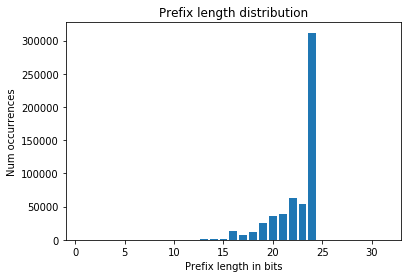

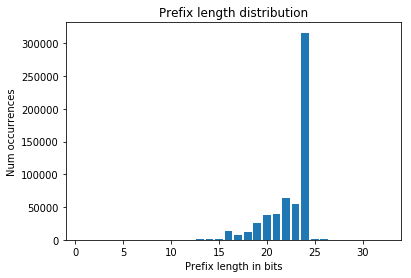

In [27]:
plot_prefix_distribution(prefixes_au)
plot_prefix_distribution(prefixes_tokyo)

In [28]:
strides_tokyo, nodes_tokyo = algos.fixed_strides_2(prefixes_tokyo)

binary_search_mms with k=32 and p=405670 yielded max memory of: 405670


In [29]:
strides_au, nodes_au = algos.fixed_strides_2(prefixes_au)

binary_search_mms with k=31 and p=398376 yielded max memory of: 398376


In [30]:
def append_stats(row: pd.Series, nodes: list):
    strides = row['Config'].replace('{', ' ').replace('}',' ').replace(',',' ').split()
    strides = [int(x) for x in strides]
    tmp, strides_nodes, cost, percent = utils.get_stats(nodes, strides, ignore_last_level=True)
    build_and_find = float(row['Build']) + float(row['Find'])
    build_and_match = float(row['Build']) + float(row['Match'])
    match_and_find = float(row['Match']) + float(row['Find'])
    return pd.Series([cost, percent, build_and_find, build_and_match, match_and_find])
    

In [31]:
newcol_names = ['Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch', 'MatchAndFind']
newcols_au = results_au_32bit.apply(lambda row: append_stats(row, nodes_au), axis=1)
newcols_tokyo = results_tokyo.apply(lambda row: append_stats(row, nodes_tokyo), axis=1)
newcols_au.columns = newcol_names
newcols_tokyo.columns = newcol_names
results_au_32bit = results_au_32bit.join(newcols_au)
results_tokyo = results_tokyo.join(newcols_tokyo)

Attempting to find cost at level: 32 when len(nodes) is:  31
Attempting to find cost at level: 33 when len(nodes) is:  31
Attempting to find cost at level: 34 when len(nodes) is:  31
Attempting to find cost at level: 35 when len(nodes) is:  31
Attempting to find cost at level: 36 when len(nodes) is:  31
Attempting to find cost at level: 37 when len(nodes) is:  31
Attempting to find cost at level: 38 when len(nodes) is:  31
Attempting to find cost at level: 39 when len(nodes) is:  31


In [32]:
results_au_32bit = results_au_32bit.sort_values('MatchAndFind')
results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,RandomMatch,RandomSort,RandomSortedMatch
23,"{3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.674880,7.820736,9.495616,84.878944,3360524,1596820.0,0.630176,23.113024,0.535392
24,"{1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",2.086752,7.741792,9.828544,64.191811,3364564,1595754.0,1.078528,24.907104,0.795840
25,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.975168,8.420448,10.395616,96.345444,3361708,1596924.0,0.779264,27.289761,0.593216
33,"{16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.299040,20.669855,21.968895,53.926208,3604428,1589780.0,34.374687,16.878304,34.415840
32,"{3, 5, 4, 4, 2, 2, 2, 2, 8, 1, 1, 1, 1, 1, 1, ...",8.755872,15.190176,23.946048,41.038368,2274564,1375572.0,8.708704,15.799712,8.411968
9,"{14, 2, 2, 2, 2, 2, 8}",1.024960,24.973633,25.998593,26.590464,2874868,1356220.0,4.872288,6.845664,4.555232
14,"{7, 7, 2, 2, 2, 2, 2, 8}",1.323072,24.823999,26.147071,31.921696,2830684,1354172.0,4.089216,7.941824,1.394912
20,"{8, 8, 2, 2, 2, 2, 8}",0.973760,25.542433,26.516193,25.324608,2846812,1356796.0,8.242112,6.347328,8.204960
26,"{2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2}",1.507200,25.736193,27.243393,48.455265,2825220,1355912.0,0.605536,14.050240,0.416160
31,"{3, 5, 4, 4, 2, 2, 2, 2, 8}",1.130656,26.432159,27.562815,31.261057,2817516,1350228.0,0.711104,8.476896,0.631936


In [33]:
results_tokyo = results_tokyo.sort_values('TreeMemoryUniqueOnly')
results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'RandomMatch', 'RandomSort', 'RandomSortedMatch']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,RandomMatch,RandomSort,RandomSortedMatch
15,"{8, 8, 16}",10.626336,60.173985,70.800321,13.730496,2358400,53504.0,8.934496,2.549184,9.243584
1,"{16, 16}",10.722880,60.488831,71.211711,13.332384,2577168,65536.0,32.785408,1.912160,31.649952
12,"{6, 6, 4, 4, 4, 8}",1.667712,35.909248,37.576960,21.203327,2774408,1984064.0,1.318944,5.004064,0.558688
11,"{12, 4, 4, 4, 8}",1.593024,35.505825,37.098849,18.488289,2782048,1984512.0,1.673536,5.156896,1.565248
17,"{8, 8, 4, 4, 8}",1.583040,35.543007,37.126047,21.068768,2797048,1990208.0,8.477312,4.196352,8.319232
10,"{14, 5, 5, 8}",2.684672,35.628319,38.312991,17.655680,2849040,2715680.0,5.010816,4.190240,4.406304
21,"{4, 4, 4, 4, 4, 4, 4, 4}",1.842176,35.865150,37.707326,25.751040,2869952,1999856.0,0.745888,7.680640,0.605152
14,"{7, 7, 4, 4, 2, 8}",0.947680,33.090431,34.038111,21.529152,2926160,1653940.0,3.800352,4.972480,1.383136
30,"{3, 5, 4, 4, 2, 2, 2, 2, 8}",1.125216,26.835680,27.960896,26.623743,2944592,1382364.0,0.718592,6.851712,0.552320
13,"{7, 7, 2, 2, 2, 2, 2, 8}",1.012352,25.353727,26.366079,26.443071,2958568,1386388.0,3.839136,6.726432,1.316544


In [34]:
results_au_32bit = results_au_32bit.sort_values('TreeMemoryUniqueOnly')
results_au_32bit[['Config', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'TreeLevels', 'ChildrenMemory', 'ChildrenCountsMemory', 'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory', 'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,TreeMemoryUniqueOnly,Cost,Percent,TreeLevels,ChildrenMemory,ChildrenCountsMemory,ScanMemory,PreScanMemory,PermuationMemory,LengthsMemory,MasksPartsMemory,ContainerSumMemory,ContainerItemsMemory,ContainerStartsMemory,ContainerLengthsMemory
32,"{3, 5, 4, 4, 2, 2, 2, 2, 8, 1, 1, 1, 1, 1, 1, ...",2274564,1375572.0,86.139283,"{1,1,1,1,40,56,99,158,194,}",6000,36,72,72,2263796,2263796,2263796,2268384,2263796,2312,2276
16,"{8, 8, 16}",2309620,53760.0,3.366489,"{1,40,425,}",42000,12,12,12,2263796,2263796,2263796,2267584,2263796,1900,1888
2,"{16, 16}",2529420,65536.0,4.103910,"{1,425,}",262152,8,8,8,2263796,2263796,2263796,2267244,2263796,1728,1720
13,"{6, 6, 4, 4, 4, 8}",2623452,1934224.0,121.122464,"{1,40,124,425,4268,222,}",318824,24,24,24,2263796,2263796,2263796,2304556,2263796,20392,20368
12,"{12, 4, 4, 4, 8}",2628980,1934672.0,121.150518,"{1,124,425,4268,222,}",324704,20,20,20,2263796,2263796,2263796,2304216,2263796,20220,20200
22,"{4, 4, 4, 4, 4, 4, 4, 4}",2631476,1935744.0,121.217647,"{1,16,40,124,425,4268,222,57,}",326200,32,32,32,2263796,2263796,2263796,2305180,2263796,20708,20676
18,"{8, 8, 4, 4, 8}",2645972,1940720.0,121.529248,"{1,40,425,4268,222,}",342368,20,20,20,2263796,2263796,2263796,2303544,2263796,19884,19864
11,"{14, 5, 5, 8}",2660524,2647968.0,165.817613,"{1,201,2220,222,}",375448,16,16,16,2263796,2263796,2263796,2285028,2263796,10624,10608
21,"{4, 4, 4, 4, 8, 8}",2717436,5429088.0,339.973299,"{1,16,40,124,425,222,}",446824,24,24,24,2263796,2263796,2263796,2270540,2263796,3384,3360
17,"{8, 8, 8, 8}",2746636,5435648.0,340.384090,"{1,40,425,222,}",477208,16,16,16,2263796,2263796,2263796,2269380,2263796,2800,2784


In [35]:
results_tokyo = results_tokyo.sort_values('Match')
results_tokyo[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,Percent,ChildrenMemory,ContainerStartsMemory,ContainerLengthsMemory
52,"{20, 3, 1, 8}",0.779456,181.646591,182.426047,17.328287,7257904,2250966.0,137.619219,4627056,161716,161700
42,"{18, 3, 2, 1, 8}",0.782784,45.048321,45.831105,20.304031,4206824,1626566.0,99.444746,1527624,185888,185868
35,"{17, 2, 2, 2, 9}",0.795488,33.530174,34.325662,20.925472,3426296,1100844.0,67.303234,740448,189212,189192
53,"{20, 2, 1, 1, 8}",0.819456,180.975616,181.795072,21.070305,7455000,2171256.0,132.745921,4684968,231304,231284
43,"{17, 3, 2, 1, 1, 8}",0.830016,35.506943,36.336959,21.647552,3837824,1529352.0,93.501291,1057200,236596,236572
51,"{21, 2, 1, 8}",0.845984,320.700897,321.546881,18.841503,11469576,3034342.0,185.513142,8805856,178152,178136
54,"{20, 1, 1, 1, 1, 8}",0.853248,180.019394,180.872642,21.993889,7561408,2237836.0,136.816479,4717848,268064,268040
44,"{17, 3, 2, 1, 1, 3, 5}",0.862432,35.206272,36.068704,24.730623,3888256,1537288.0,93.986481,1107096,236860,236832
37,"{18, 4, 2, 8}",0.864160,46.939007,47.803167,16.929024,3925080,1753908.0,107.230162,1450488,83588,83572
41,"{19, 3, 2, 8}",0.892608,89.083870,89.976478,16.948223,4954664,1762492.0,107.754969,2471512,87868,87852


In [36]:
results_au_32bit = results_tokyo.sort_values('Find')
results_au_32bit[['Config', 'Match', 'Find', 'MatchAndFind', 'Build', 'TreeMemoryUniqueOnly', 'Cost', 'Percent', 'ChildrenMemory', 'ContainerStartsMemory', 'ContainerLengthsMemory']]

,Config,Match,Find,MatchAndFind,Build,TreeMemoryUniqueOnly,Cost,Percent,ChildrenMemory,ContainerStartsMemory,ContainerLengthsMemory
23,"{1, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.498560,7.542976,9.041536,56.362080,3554832,1634482.0,99.928713,627448,309908,309816
22,"{3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.719200,8.018752,9.737952,73.707329,3550600,1635544.0,99.993642,621432,310784,310676
24,"{1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2.118464,8.628256,10.746720,79.562561,3551560,1635648.0,100.000000,621616,311152,311024
32,"{16, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1.300544,21.768192,23.068736,47.521248,3783384,1628146.0,99.541344,868776,303544,303476
13,"{7, 7, 2, 2, 2, 2, 2, 8}",1.012352,25.353727,26.366079,26.443071,2958568,1386388.0,84.760780,432104,109508,109476
8,"{14, 2, 2, 2, 2, 2, 8}",1.026784,25.376480,26.403264,23.408129,3003792,1388436.0,84.885990,477664,109344,109316
25,"{2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2}",1.401536,26.258976,27.660512,43.393761,2983304,1392816.0,85.153774,450200,112796,112732
7,"{16, 2, 2, 2, 2, 8}",0.968608,26.636641,27.605249,26.268192,3190592,1400628.0,85.631383,667752,107704,107680
46,"{12, 4, 2, 2, 2, 1, 1, 3, 5}",1.072928,26.651264,27.724192,28.435007,3408608,1477856.0,90.352937,613608,243772,243736
48,"{12, 4, 2, 2, 2, 1, 1, 2, 1, 2, 3}",1.057056,26.731680,27.788736,31.489729,3392064,1474832.0,90.168056,593224,245684,245640


In [37]:
results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Match'])

0.906634164069544

In [38]:
results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Find'])

0.9856800527977614

In [39]:
results_au_32bit['TreeMemoryUniqueOnly'].corr(results_au_32bit['Build'])

-0.13107164740897956

In [40]:
results_tokyo['ChildrenMemory'].corr(results_au_32bit['Cost'])

0.6535874152419291

In [41]:
results_au_32bit['ChildrenMemory'].corr(results_au_32bit['Cost'])

0.6535874152419291

In [42]:
results_au_32bit['Match'].corr(results_au_32bit['Cost'])

0.7069712016996599

In [43]:
results_tokyo['Match'].corr(results_au_32bit['Cost'])

0.7069712016996599

In [44]:
results_tokyo.columns

Index(['deviceId', 'deviceName', 'Dictionary', 'Load', 'Count', 'Sort',
       'Config', 'Reshape', 'Build', 'TreeMemory', 'TreeLevels', 'Depth',
       'TreeMemoryUniqueOnly', 'ChildrenMemory', 'ChildrenCountsMemory',
       'ScanMemory', 'PreScanMemory', 'PermuationMemory', 'LengthsMemory',
       'MasksPartsMemory', 'ContainerSumMemory', 'ContainerItemsMemory',
       'ContainerStartsMemory', 'ContainerLengthsMemory', 'Find', 'Match',
       'RandomCount', 'RandomMatch', 'RandomSort', 'RandomSortedMatch',
       'HitRate', 'Cost', 'Percent', 'BuildAndFind', 'BuildAndMatch',
       'MatchAndFind'],
      dtype='object')

In [45]:
# results_tokyo[['Config', 'Build', 'Cost', 'Percent', 'TreeMemory','BuildAndFind', 'Match', 'Find', 'RandomMatch', 'RandomSortedMatch']]

In [46]:
# results_au_32bit[['Config', 'Build', 'TreeMemory', 'Match', 'Find','BuildAndFind','RandomCount', 'RandomMatch', 'RandomSort', 'RandomSortedMatch', 'HitRate', 'Cost', 'Percent']]